## Beyond Linearity 1

We need to add some additional packages to make this work.

So start with *pip3 install ISLP*.  ISLP is a package from a book entitled 'Introduction to Statistical Learning with Python'.

We'll also need the *pygam* package.

Then *pip3 install pygam*

In [2]:
!pip3 install ISLP
!pip3 install pygam


In [3]:
import numpy as np, pandas as pd
from matplotlib.pyplot import subplots
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (summarize,                         
                         poly, 
                         ModelSpec as MS)
from statsmodels.stats.anova import anova_lm
import matplotlib.pyplot as plt

In [4]:

from ISLP.transforms import (BSpline,
                             NaturalSpline)
from ISLP.models import bs, ns
from ISLP.pygam import (approx_lam,
                        degrees_of_freedom,
                        plot as plot_gam,
                        anova as anova_gam)

We are going to start with some data on wages.  We'll look at the data on wages with age as a predictor.

In [5]:
Wage = load_data('Wage')
print(Wage.info())
y = Wage['wage']
age = Wage['age']
Wage.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   year        3000 non-null   int64   
 1   age         3000 non-null   int64   
 2   maritl      3000 non-null   category
 3   race        3000 non-null   category
 4   education   3000 non-null   category
 5   region      3000 non-null   category
 6   jobclass    3000 non-null   category
 7   health      3000 non-null   category
 8   health_ins  3000 non-null   category
 9   logwage     3000 non-null   float64 
 10  wage        3000 non-null   float64 
dtypes: category(7), float64(2), int64(2)
memory usage: 115.5 KB
None


,year,age,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,2006,18,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,2004,24,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,2003,45,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
3,2003,43,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
4,2005,50,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154


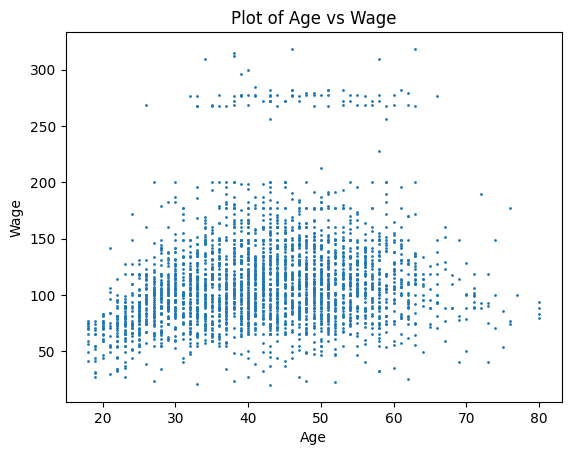

In [6]:
plt.scatter( Wage['age'],Wage['wage'],s=1)

# Add labels and title
plt.xlabel('Age')
plt.ylabel('Wage' )
plt.title('Plot of Age vs Wage')
plt.show()

So that scatterplot suggests that we have a non-linear relationship here.

So let's build some non-linear models.

### Polynomial Regression

Polynomial regression means that we have a regression with predictors $x$, $x^2$, $x^3$, ..., to $x^d$ where
$d$ is the degree of the polynomial.  So a cubic is of degree 3 and a linear function would be of degree 1.

We will do this in a special way that make the predictors not be correlated.  Math.

In [7]:
# This builds the fourth degree polynomial predictors for age
# so that we have in poly_age: age, age^2, age^3, age^4
poly_age = MS([poly('age', degree=4)]).fit(Wage)
# Use the polynomials of age to fit a regression model an 
# ordinary least squares (OLS) one 
M = sm.OLS(y, poly_age.transform(Wage)).fit()
# get the summary for this model
summarize(M)


,coef,std err,t,P>|t|
intercept,111.7036,0.729,153.283,0.000
"poly(age, degree=4)[0]",447.0679,39.915,11.201,0.000
"poly(age, degree=4)[1]",-478.3158,39.915,-11.983,0.000
"poly(age, degree=4)[2]",125.5217,39.915,3.145,0.002
"poly(age, degree=4)[3]",-77.9112,39.915,-1.952,0.051


In the output above, we have the y-intercept (111.7), then the coefficient for age (447.1), the coefficient for age^2 (-478.3),
    the coefficient for age^3 (125.5) and the coefficient for age^4 (-77.9).

For making predictions, we create a set of values in *age_grid* and then we'll match the structure of the polynomials
by transforming them to make them not correlated as we did above.

In [8]:
# make a set of 63 values from the smallest age to the largest age
# note that we made the number of values to be 63 so that we have predictions at each age.

age_grid = np.linspace(age.min(),
                       age.max(),
                       63)
print(age_grid)

# put those values into a dataframe called age_df
age_df = pd.DataFrame({'age': age_grid})
# make the values at which we are going to predict and transform them 
Xnew = poly_age.transform(age_df)
# generated predicted values at the values in age_grid
preds = M.get_prediction(Xnew)

#print(preds.summary_frame())
age_df['preds']=preds.predicted_mean


[18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53.
 54. 55. 56. 57. 58. 59. 60. 61. 62. 63. 64. 65. 66. 67. 68. 69. 70. 71.
 72. 73. 74. 75. 76. 77. 78. 79. 80.]


Below we make a plot and add the prediction equation in red to the plot.

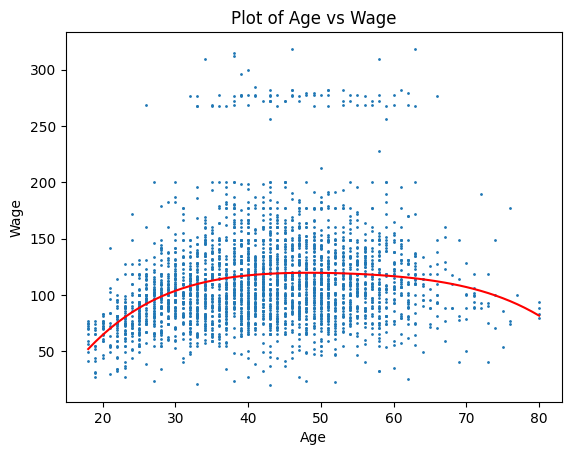

In [9]:
plt.scatter( Wage['age'],Wage['wage'],s=1)

# Add labels and title
plt.xlabel('Age')
plt.ylabel('Wage' )
plt.title('Plot of Age vs Wage')


# Add regression line to plot
plt.plot(age_df['age'],age_df['preds'] , color='red')

plt.show()

The above plot is the fourth order polynomial model for prediction of an individuals wage by age.

Note that the model is not quadratic as it has an extended area of peak which is not 
the form that a quadratic would take.

### Splines

Polynomials give us some flexibility in the relationship between our response/target and our features/predictors.  A *spline* is another way to build some flexibility into that relationship.

The idea of a spliced lines, or splines, is to fit a functional curve, by default cubic, to data in a window, then fit another  curve to the next window, etc through all the windows, and have the lines be spliced together.  Where the windows come together are called knots because they 'tie together' one curve to the next.

We do this by creating bases, see Linear Algebra, as predictors which are effectively perpendicular to each other.

The `BSpline()`  function generates the  entire matrix of basis functions for splines with the specified set of knots. By default, the B-splines produced are cubic. To change the degree, use the argument `degree`.

In [10]:
# BSplines are basis splines (bs)
# basically these are orthogonal, read perpendicular, predictors that ensure there 
# is not much multicollinearity between them
# the knots are the locations on the x axis
bs_1 = BSpline(internal_knots=[25,40,60], intercept=True).fit(age)
# transform the splines to fit the age and the function below
bs_age = bs_1.transform(age)
# get the number of rows and columns for bs_age
bs_age.shape

(3000, 7)

The next set of code makes the necessary predictors to have splines between knots 
at ages 25, 40 and 60.  

In [11]:
bs_age = MS([bs('age', degree=3,internal_knots=[25,40,60])])
# MS is a function that takes python sequences and makes them into a matrix
Xbs = bs_age.fit_transform(Wage)
# The fit_transform() method in Python, particularly within the scikit-learn library, 
# serves as a combined operation of fitting and transforming data. 
# It is commonly used in data preprocessing steps for machine learning. 
# The fit() part calculates necessary parameters from the data, 
# such as mean and standard deviation in the case of scaling. 
# The transform() part then applies these calculated parameters to transform the data. 
# Using fit_transform() performs both actions sequentially in a single step, 
# which can be more efficient than calling fit() and transform() separately.

# fit a regression model to these data with y as the response and Xbs as our predictors
# call that model M2
M2 = sm.OLS(y, Xbs).fit()
# get the coefficient summary for M2
summarize(M2)

,coef,std err,t,P>|t|
intercept,60.4937,9.460,6.394,0.000
"bs(age, degree=3, internal_knots=[25, 40, 60])[0]",3.9805,12.538,0.317,0.751
"bs(age, degree=3, internal_knots=[25, 40, 60])[1]",44.6310,9.626,4.636,0.000
"bs(age, degree=3, internal_knots=[25, 40, 60])[2]",62.8388,10.755,5.843,0.000
"bs(age, degree=3, internal_knots=[25, 40, 60])[3]",55.9908,10.706,5.230,0.000
"bs(age, degree=3, internal_knots=[25, 40, 60])[4]",50.6881,14.402,3.520,0.000
"bs(age, degree=3, internal_knots=[25, 40, 60])[5]",16.6061,19.126,0.868,0.385


Notice that there are 6 spline coefficients rather than 7. This is because, by default, `bs()` assumes `intercept=False`, since we typically have an overall intercept in the model. So it generates the spline basis with the given knots,  and then discards one of the basis functions to account for the intercept. 

We could also use the `df` (degrees of freedom) option to specify the complexity of the spline.  We see above that with 3 knots, the spline basis has 6 columns or degrees of freedom.  When we specify `df=6` rather than the actual knots, `bs()` will produce a spline with 3 knots chosen at uniform quantiles of the training data.  

We can see these chosen knots most easily using `Bspline()` directly:

In [12]:
BSpline(df=6).fit(age).internal_knots_


array([33.75, 42.  , 51.  ])

The degrees of freedom that a model uses are the number of knots plus the degree of the polynomial that is fit.  

So df = degree + knots

So for a model that is df=6 and degree=3, there will be three knots.

So if give BSpline df=7 and degree=2, then there will be 5 knots.

In [26]:
BSpline(df=7, degree=2).fit(age).internal_knots_

array([30., 37., 42., 48., 54.])

Next we will make predictions so we can plot and compare how the splines do compared to the polynomial regression.

In [13]:
# create the data for making predictions based upon the bs_age transformation
Xnew = bs_age.transform(age_df)
# get the predicted values from M2 which is our regression model
preds2 = M2.get_prediction(Xnew)

# M2.get_prediction gives a bunch of output we just wanted the predicted values/means
age_df['preds2']=preds2.predicted_mean

Below is the full model output that we are used to seeing.  

In [14]:
print(M2.summary())

                            OLS Regression Results                            
Dep. Variable:                   wage   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     47.19
Date:                Tue, 10 Feb 2026   Prob (F-statistic):           1.53e-55
Time:                        16:36:48   Log-Likelihood:                -15314.
No. Observations:                3000   AIC:                         3.064e+04
Df Residuals:                    2993   BIC:                         3.068e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------

Next make the plots and compare the polynomial in *red* to the splines in *blue*.

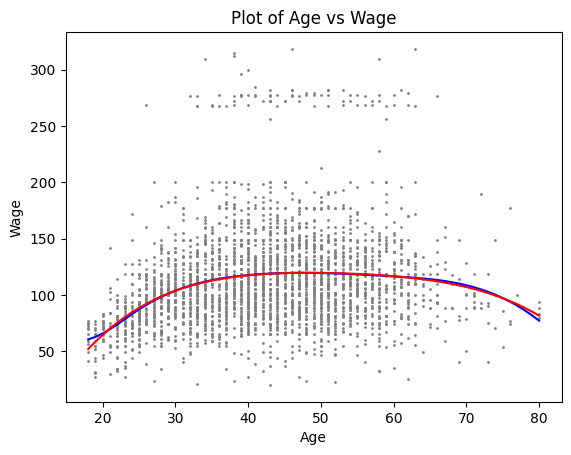

In [15]:
plt.scatter( Wage['age'],Wage['wage'],s=1, color="grey")

# Add labels and title
plt.xlabel('Age')
plt.ylabel('Wage' )
plt.title('Plot of Age vs Wage')


# Add prediction line to plot
plt.plot(age_df['age'],age_df['preds2'] , color='blue')
# Add prediction line to plot
plt.plot(age_df['age'],age_df['preds'],color="red")

plt.show()

The predictions are similar but with some slight differences between the polynomial and the spline fit.
If we were to change the polynomial order or the type of spline we would get different predictions.



Below we will change the type of spline to be linear (degree=1) and refit the model. 

In [16]:
bs_age2 = MS([bs('age', degree=1,internal_knots=[25,40,60])])
# MS is a function that takes python sequences and makes them into a matrix
Xbs2 = bs_age2.fit_transform(Wage)
# The fit_transform() method in Python, particularly within the scikit-learn library, 
# serves as a combined operation of fitting and transforming data. 
# It is commonly used in data preprocessing steps for machine learning. 
# The fit() part calculates necessary parameters from the data, 
# such as mean and standard deviation in the case of scaling. 
# The transform() part then applies these calculated parameters to transform the data. 
# Using fit_transform() performs both actions sequentially in a single step, 
# which can be more efficient than calling fit() and transform() separately.

# fit a regression model to these data with y as the response and Xbs as our predictors
# call that model M3
M3 = sm.OLS(y, Xbs2).fit()
# get the coefficient summary for M2
summarize(M3)

,coef,std err,t,P>|t|
intercept,54.3328,5.957,9.120,0.000
"bs(age, degree=1, internal_knots=[25, 40, 60])[0]",37.6451,6.817,5.522,0.000
"bs(age, degree=1, internal_knots=[25, 40, 60])[1]",65.8474,6.019,10.940,0.000
"bs(age, degree=1, internal_knots=[25, 40, 60])[2]",63.8504,6.319,10.104,0.000
"bs(age, degree=1, internal_knots=[25, 40, 60])[3]",33.7715,10.580,3.192,0.001


We've not interpreted these coefficients since they are a challenge to interpret since they depend upon the basis functions that were defined.  What we can tell is that since all of the above coefficients have small p-values, that they are worth keeping in the model.

In [17]:
print(M3.summary())

                            OLS Regression Results                            
Dep. Variable:                   wage   R-squared:                       0.087
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     71.03
Date:                Tue, 10 Feb 2026   Prob (F-statistic):           1.49e-57
Time:                        16:36:48   Log-Likelihood:                -15314.
No. Observations:                3000   AIC:                         3.064e+04
Df Residuals:                    2995   BIC:                         3.067e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------

Next we will get the predictions for the model *M3*.

In [18]:
Xnew = bs_age2.transform(age_df)

preds3 = M3.get_prediction(Xnew)

#print(preds.summary_frame())
age_df['preds3']=preds3.predicted_mean

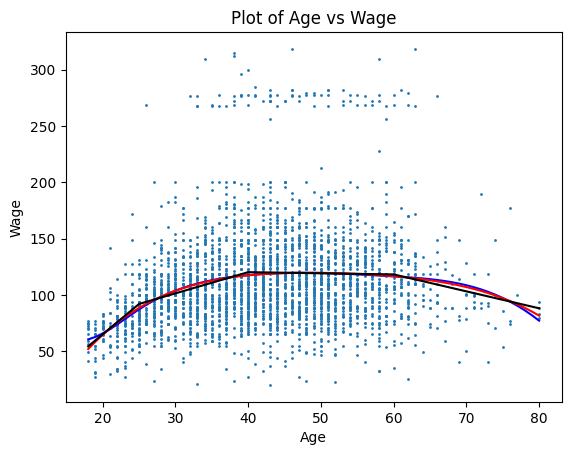

In [19]:
plt.scatter( Wage['age'],Wage['wage'],s=1)

# Add labels and title
plt.xlabel('Age')
plt.ylabel('Wage' )
plt.title('Plot of Age vs Wage')


# Add prediction line to plot
plt.plot(age_df['age'],age_df['preds2'] , color='blue')
# Add prediction line to plot
plt.plot(age_df['age'],age_df['preds'],color="red")
# Add prediction line for degree =2 spline
plt.plot(age_df['age'],age_df['preds3'],color="black")

plt.show()

Let's change the y-axis so that we can more closely see that is going on.  

We'll do that below with the *plt.ylim* command.

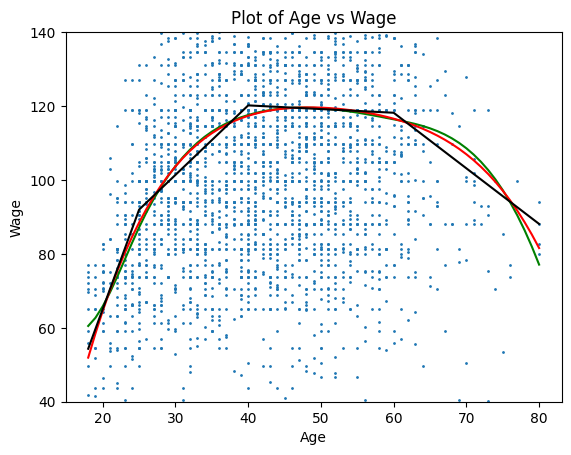

In [20]:
# note here that the addition of s=1 makes for 
plt.scatter( Wage['age'],Wage['wage'],s=1)

# Add labels and title
plt.xlabel('Age')
plt.ylabel('Wage' )
plt.title('Plot of Age vs Wage')


# Add prediction line to plot
plt.plot(age_df['age'],age_df['preds2'] , color='green')
# Add prediction line to plot
plt.plot(age_df['age'],age_df['preds'],color="red")
# Add prediction line for degree =2 spline
plt.plot(age_df['age'],age_df['preds3'],color="black")

plt.ylim([40,140])
plt.show()

We specified knots at Age = 25, Age = 40, and Age =60.  From the black curve, which has a linear fit in each window we can clearly see the 'elbows' at those age values where the predicted curve changes slope while still being 'smooth' (or even continuous in a mathematical sense).



### Step Functions 

To get a step function we choose the basis spline with *degree=0*.

In [21]:
bs_age4 = MS([bs('age', degree=0,internal_knots=[25,40,60])])
# MS is a function that takes python sequences and makes them into a matrix
Xbs4 = bs_age4.fit_transform(Wage)
# The fit_transform() method in Python, particularly within the scikit-learn library, 
# serves as a combined operation of fitting and transforming data. 
# It is commonly used in data preprocessing steps for machine learning. 
# The fit() part calculates necessary parameters from the data, 
# such as mean and standard deviation in the case of scaling. 
# The transform() part then applies these calculated parameters to transform the data. 
# Using fit_transform() performs both actions sequentially in a single step, 
# which can be more efficient than calling fit() and transform() separately.

# fit a regression model to these data with y as the response and Xbs as our predictors
# call that model M4
M4 = sm.OLS(y, Xbs4).fit()
# get the coefficient summary for M2
summarize(M4)

,coef,std err,t,P>|t|
intercept,73.3444,3.050,24.046,0.0
"bs(age, degree=0, internal_knots=[25, 40, 60])[0]",34.3500,3.297,10.420,0.0
"bs(age, degree=0, internal_knots=[25, 40, 60])[1]",44.9781,3.215,13.989,0.0
"bs(age, degree=0, internal_knots=[25, 40, 60])[2]",40.5894,4.130,9.828,0.0


In [22]:
Xnew = bs_age4.transform(age_df)

preds4 = M4.get_prediction(Xnew)

#print(preds.summary_frame())
age_df['preds4']=preds4.predicted_mean

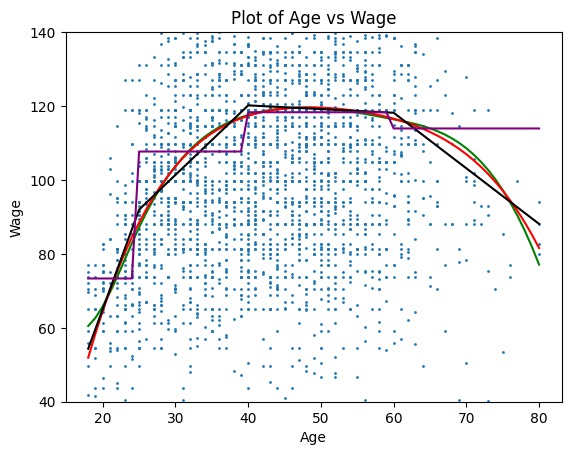

In [23]:
# note here that the addition of s=1 makes for 
plt.scatter( Wage['age'],Wage['wage'],s=1)

# Add labels and title
plt.xlabel('Age')
plt.ylabel('Wage' )
plt.title('Plot of Age vs Wage')


# Add prediction line to plot
plt.plot(age_df['age'],age_df['preds2'] , color='green')
# Add prediction line to plot
plt.plot(age_df['age'],age_df['preds'],color="red")
# Add prediction line for degree =2 spline
plt.plot(age_df['age'],age_df['preds3'],color="black")
#Add prediction line for degree = 0 spline
plt.plot(age_df['age'],age_df['preds4'],color="purple")

plt.ylim([40,140])
plt.show()

Tasks

1. Read in National Football League historical draft data located at http://myslu.stlawu.edu/~msch/data/NFLDraft.csv .  *G* is the number of games played by a player in their career. *Pick* is the position at which they were selected in the National Football League (NFL) draft. Plot *G* vs *Pick*.  The NFL allocates new players to teams by having teams select among a pool of available players.  There are multiple rounds (*Rnd*) and each team starts with one *Pick* per round.  In theory, the best players are selected with the lowest *Pick* values.

2. With *G* as the response and *Pick* as the predictor, (1) fit a 4th degree polynomial, and (2) a basis spline with four knots at 30, 60, 90 and 120 that is degree 3, and (3) another basis spline with the same knots that is degree 1.

3. Plot the predicted functions for your models above.

4. For the models that you made, what is the predicted value for *G* for a player who is the 10th pick (*Pick*=10).
    
5. How might you evaluate which of these three models does the best job of prediction?  


In [24]:
# read in the blue jay data
nfl = pd.read_csv("http://myslu.stlawu.edu/~msch/data/NFLDraft.csv")
# remove rows with missing data
#nfl.dropna(inplace=True)

nfl.head()


,Year,Rnd,Pick,Tm,,Pos,To,AP1,PB,GS,...,RushYds,RushTD,Rec,RecYds,RecTD,Tkl,Int,Sk,College/Univ,TradPower
0,1992,12,332,HOU,Joe Wood,K,NaN,0,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Air Force,0
1,1995,7,218,DEN,Steve Russ,LB,2000.0,0,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Air Force,0
2,1997,6,178,SDG,Daniel Palmer,C,NaN,0,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Air Force,0
3,1999,7,248,BUF,Bryce Fisher,DE,2007.0,0,0,NaN,...,NaN,NaN,NaN,NaN,NaN,176,NaN,26.5,Air Force,0
4,1993,8,224,TAM,Daron Alcorn,K,NaN,0,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Akron,0


In [25]:
# the code below fills in missing values with zeros for each features/columns.
# we do this since if a player did not have a value we assume they 
# never played in a game, 'G  '
# or never started a game 'GS'
# or never had any career approximate value 'CarAV  '
nfl['G  ']=nfl['G  '].fillna(0)
nfl['GS']=nfl['GS'].fillna(0)
nfl['CarAV  ']=nfl['CarAV  '].fillna(0)
